In [11]:
import sqlalchemy
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
Base= automap_base()
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
from flask import Flask, jsonify

In [12]:
database_path='C:\workspace\Resources\hawaii.sqlite'
engine=create_engine(f'sqlite:///{database_path}')
conn= engine.connect()

In [13]:
Base.prepare(engine, reflect= True)
Base.classes.keys()

['measurement', 'station']

In [14]:
Measurement= Base.classes.measurement
Station= Base.classes.station

In [15]:
df_measurement=pd.read_sql("Select * from measurement",conn)
df_measurement

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [16]:
df_station=pd.read_sql("Select * from station",conn)
df_station

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [17]:
session= Session(engine)


In [18]:
# Precipitation Analysis
twelve_month_ago = dt.date(2017,8,23) - relativedelta(months=+12)
now= dt.date(2017,8,23)
prcp_12=session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date <=now).\
        filter(Measurement.date >= twelve_month_ago).all()
df_prcp_12=pd.DataFrame(prcp_12, columns=['date','prcp'])
df_prcp_12_clean=df_prcp_12.dropna()
df_prcp_12_clean.set_index('date', inplace= True)
df_prcp_12_clean=df_prcp_12_clean.sort_index()
df_prcp_12_clean

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


In [19]:
# dictionary = df_prcp_12.to_dict(orient="index")
# dictionary

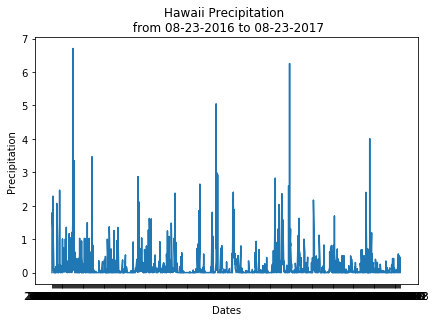

In [20]:
plt.plot(df_prcp_12_clean)
plt.tight_layout()
plt.xlabel("Dates")
plt.ylabel("Precipitation")
plt.title("Hawaii Precipitation \n from 08-23-2016 to 08-23-2017")
plt.show()

In [21]:
stastistic_nums= df_prcp_12_clean.describe()
stastistic_nums

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Station Analysis
# Total numbers of stations
session.query(func.count(Station.station)).all()

[(9)]

In [23]:
# Most active stations
## List the stations and observation counts in descending order
station_counts=[Station.station, func.count(Measurement.tobs)]
obser_count=session.query(*station_counts).\
    filter(Station.station==Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
obser_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
## Most active stations
most_active=session.query(*station_counts).\
    filter(Station.station==Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).\
    limit(1).all()
most_active_unzip = list(np.ravel(most_active))
most_active_unzip

['USC00519281', '2772']

In [25]:
# Least active stations
## List the stations and observation counts in descending order
obser_count_asc=session.query(*station_counts).\
    filter(Station.station==Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs)).all()
obser_count_asc

[('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00519523', 2669),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519281', 2772)]

In [26]:
## Least active stations
least_active= session.query(*station_counts).\
    filter(Station.station==Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs)).\
    limit(1).all()
least_active_unzip = list(np.ravel(least_active))
least_active_unzip

['USC00518838', '511']

In [27]:
# 12 month temperatures in the most active station
temp_12=session.query(Measurement.date, Measurement.tobs).\
    filter(Station.station==Measurement.station).\
    filter(Station.station==most_active_unzip[0]).\
    filter(Measurement.date <=now).\
    filter(Measurement.date >= twelve_month_ago).all()
df_temp_12=pd.DataFrame(temp_12, columns=['date','temp'])
df_temp_12_clean=df_temp_12.dropna()
df_temp_12_clean

,date,temp
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


In [28]:
# Min, max, avg temperatures for the most active stations
sel=[func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_data=session.query(*sel).\
    filter(Station.station==Measurement.station).\
    group_by(Measurement.station).filter(Station.station==most_active_unzip[0]).all()
most_active_data

[(54.0, 85.0, 71.66378066378067)]

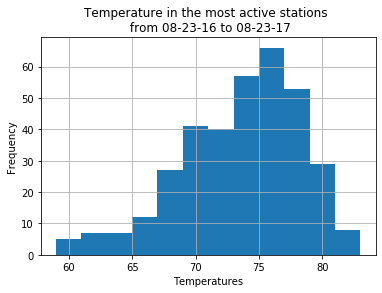

In [36]:
# Plot last 12 months of temperature histogram
plt.hist(df_temp_12_clean['temp'], bins=12)
plt.xlabel('Temperatures')
plt.ylabel('Frequency')
plt.title('Temperature in the most active stations \n from 08-23-2016 to 08-23-2017')
plt.grid()
plt.show()